In [230]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [231]:
# [X, Y] = meshgrid(1:a, 1:a)
# for i = 2:2:a
# 	X(i,:) = X(i,:) + 1/2;
# end
# Y = Y*sqrt(3)/2;
# x = X(:)
# y = Y(:)

a = 10          # Mesh width
p = 0.25        # Link probability

Y, X = np.meshgrid(np.linspace(1, a, a), np.linspace(1, a, a), sparse=False, indexing='ij')
print(X)
print(Y)

for i in np.arange(1, a+1, 2):
    X[i, :] = X[i, :] + 1/2
    
Y = Y*np.sqrt(3)/2
x = np.reshape(X, (-1), order='F')
y = np.reshape(Y, (-1), order='F')
print(x)
print(y)

[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  7.  7.  7.  7.  7.  7.  7.  7.  7.]
 [ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.]
 [ 9.  9.  9.  9.  9.  9.  9.  9.  9.  9.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
[ 1.   1.5  1.   1.5  1.   1.5  1.   1.5  1.   1.5  2.   2.5  2.   2.5
  2.   2.5  2.   2.5  2.   2.5  3.   3.5  3.   3.5  3.   3.5  3.   

In [154]:
# T = delaunay(x, y)

tri = sp.spatial.Delaunay(np.c_[x, y])
T = tri.simplices
print(T)

[[74 84 75]
 [33 43 44]
 [ 1  2  0]
 [ 5  6  4]
 [ 2  3  4]
 [ 7  8  6]
 [98 97 99]
 [97 98 87]
 [97 96 95]
 [96 97 87]
 [86 96 87]
 [59 49 58]
 [43 54 44]
 [65 64 74]
 [65 74 75]
 [33 42 43]
 [30 21 20]
 [10  1  0]
 [49 48 58]
 [36 25 35]
 [25 36 26]
 [15 25 26]
 [25 15 24]
 [ 1 12  2]
 [12  3  2]
 [89 98 99]
 [77 86 87]
 [68 59 58]
 [83 94 84]
 [84 85 75]
 [85 86 75]
 [96 85 95]
 [85 96 86]
 [94 85 84]
 [85 94 95]
 [94 93 95]
 [93 92 91]
 [93 83 92]
 [83 93 94]
 [45 35 44]
 [54 45 44]
 [64 63 74]
 [34 33 44]
 [35 34 44]
 [25 34 35]
 [34 25 24]
 [34 23 33]
 [23 34 24]
 [42 52 43]
 [21 32 22]
 [32 23 22]
 [23 32 33]
 [32 42 33]
 [17 18  7]
 [ 8 18  9]
 [18  8  7]
 [17 16 26]
 [16  7  6]
 [ 5 16  6]
 [16 17  7]
 [15 16  5]
 [16 15 26]
 [ 3 14  4]
 [14  5  4]
 [15 14 24]
 [14 15  5]
 [21 11 20]
 [11 21 22]
 [11 10 20]
 [10 11  1]
 [11 12  1]
 [12 11 22]
 [86 76 75]
 [76 65 75]
 [76 77 67]
 [77 76 86]
 [88 89 79]
 [89 88 98]
 [98 88 87]
 [88 77 87]
 [68 69 59]
 [48 47 58]
 [47 48 37]
 [54

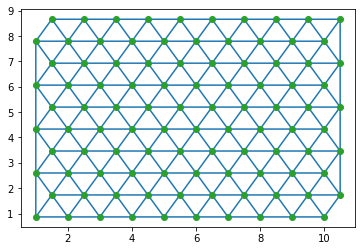

In [156]:
plt.triplot(x, y, T)
plt.plot(x, y, 'o')

In [157]:
# % Get a list of all links
# tmp = [T(:,1) T(:,2) ; T(:,1) T(:,3) ; T(:,2) T(:,3)]

tmp = np.r_[np.c_[T[:, 0], T[:, 1]],
           np.c_[T[:, 0], T[:, 2]],
           np.c_[T[:, 1], T[:, 2]]]
print(tmp)

[[74 84]
 [33 43]
 [ 1  2]
 ...
 [73 72]
 [71 81]
 [82 72]]


In [215]:
# % Filter out duplicates
# links = unique([min(tmp(:,1), tmp(:,2)), max(tmp(:,1), tmp(:,2))], 'rows');

links = np.unique(np.c_[np.minimum(tmp[:, 0], tmp[:, 1]), np.maximum(tmp[:, 0], tmp[:, 1])], axis=0)
print(links)

[[ 0  1]
 [ 0  2]
 [ 0 10]
 [ 1  2]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 2  3]
 [ 2  4]
 [ 2 12]
 [ 3  4]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 4  5]
 [ 4  6]
 [ 4 14]
 [ 5  6]
 [ 5 14]
 [ 5 15]
 [ 5 16]
 [ 6  7]
 [ 6  8]
 [ 6 16]
 [ 7  8]
 [ 7 16]
 [ 7 17]
 [ 7 18]
 [ 8  9]
 [ 8 18]
 [ 9 18]
 [ 9 19]
 [10 11]
 [10 20]
 [11 12]
 [11 20]
 [11 21]
 [11 22]
 [12 13]
 [12 22]
 [13 14]
 [13 22]
 [13 23]
 [13 24]
 [14 15]
 [14 24]
 [15 16]
 [15 24]
 [15 25]
 [15 26]
 [16 17]
 [16 26]
 [17 18]
 [17 26]
 [17 27]
 [17 28]
 [18 19]
 [18 28]
 [19 28]
 [19 29]
 [20 21]
 [20 30]
 [21 22]
 [21 30]
 [21 31]
 [21 32]
 [22 23]
 [22 32]
 [23 24]
 [23 32]
 [23 33]
 [23 34]
 [24 25]
 [24 34]
 [25 26]
 [25 34]
 [25 35]
 [25 36]
 [26 27]
 [26 36]
 [27 28]
 [27 36]
 [27 37]
 [27 38]
 [28 29]
 [28 38]
 [29 38]
 [29 39]
 [30 31]
 [30 40]
 [31 32]
 [31 40]
 [31 41]
 [31 42]
 [32 33]
 [32 42]
 [33 34]
 [33 42]
 [33 43]
 [33 44]
 [34 35]
 [34 44]
 [35 36]
 [35 44]
 [35 45]
 [35 46]
 [36 37]
 [36 46]
 [37 38]
 [37 46]
 [37 47]
 

In [229]:
# % Filter with probability p to get the random network
# L = links(rand(size(links,1),1)<=p, :)

L = links[np.random.rand(len(links)) <= p, :]
print(L)

[[ 0  2]
 [ 0 10]
 [ 2 12]
 [ 3  4]
 [ 4  6]
 [ 5  6]
 [ 5 16]
 [ 6  7]
 [ 6 16]
 [ 7 16]
 [ 8  9]
 [10 11]
 [13 24]
 [15 25]
 [21 30]
 [21 31]
 [21 32]
 [23 24]
 [23 32]
 [24 25]
 [25 35]
 [28 29]
 [30 40]
 [34 44]
 [37 38]
 [37 46]
 [39 48]
 [40 41]
 [41 50]
 [42 52]
 [43 44]
 [44 45]
 [49 58]
 [51 52]
 [52 53]
 [53 64]
 [55 65]
 [57 66]
 [57 67]
 [58 59]
 [63 64]
 [63 74]
 [64 74]
 [65 74]
 [66 76]
 [67 68]
 [67 78]
 [71 82]
 [72 73]
 [73 83]
 [74 75]
 [75 84]
 [75 86]
 [76 77]
 [77 87]
 [77 88]
 [79 89]
 [80 81]
 [80 90]
 [82 83]
 [83 84]
 [83 93]
 [85 86]
 [86 87]
 [87 97]
 [88 98]
 [89 98]
 [91 92]
 [93 94]
 [96 97]
 [97 99]]


In [234]:
# % Get sparse adjacency matrix
# A = sparse(L(:,1), L(:,2), ones(size(L,1),1), a^2, a^2)

A = sp.sparse.csr_matrix((np.ones(len(L)), (L[:, 0], L[:, 1])), shape=(a**2, a**2))
print(A)

  (0, 2)	1.0
  (0, 10)	1.0
  (2, 12)	1.0
  (3, 4)	1.0
  (4, 6)	1.0
  (5, 6)	1.0
  (5, 16)	1.0
  (6, 7)	1.0
  (6, 16)	1.0
  (7, 16)	1.0
  (8, 9)	1.0
  (10, 11)	1.0
  (13, 24)	1.0
  (15, 25)	1.0
  (21, 30)	1.0
  (21, 31)	1.0
  (21, 32)	1.0
  (23, 24)	1.0
  (23, 32)	1.0
  (24, 25)	1.0
  (25, 35)	1.0
  (28, 29)	1.0
  (30, 40)	1.0
  (34, 44)	1.0
  (37, 38)	1.0
  :	:
  (67, 78)	1.0
  (71, 82)	1.0
  (72, 73)	1.0
  (73, 83)	1.0
  (74, 75)	1.0
  (75, 84)	1.0
  (75, 86)	1.0
  (76, 77)	1.0
  (77, 87)	1.0
  (77, 88)	1.0
  (79, 89)	1.0
  (80, 81)	1.0
  (80, 90)	1.0
  (82, 83)	1.0
  (83, 84)	1.0
  (83, 93)	1.0
  (85, 86)	1.0
  (86, 87)	1.0
  (87, 97)	1.0
  (88, 98)	1.0
  (89, 98)	1.0
  (91, 92)	1.0
  (93, 94)	1.0
  (96, 97)	1.0
  (97, 99)	1.0


In [261]:
A.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [270]:
[x[0], x[1]]

[1.0, 1.5]

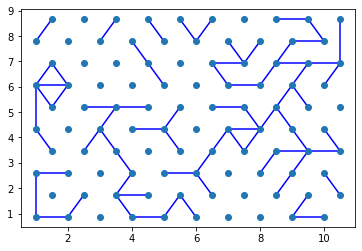

In [273]:
for ix in L:
    plt.plot([x[ix[0]], x[ix[1]]], [y[ix[0]], y[ix[1]]], 'b')
plt.plot(x, y, 'o')

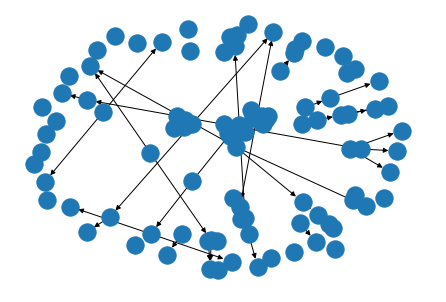

In [236]:
import networkx as nx
G = nx.DiGraph(A)
nx.draw(G)